In [457]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import random
import torch
import torch.nn as nn
import math
import torch.optim as optim
from collections import deque
from IPython import display


# Visualisation

In [459]:
def visualize(roadEnv,carEnv):
    """Visualize the road environment"""
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot center line
    center = np.array(roadEnv.center)
    ax.plot(center[:, 0], center[:, 1], 'k--', linewidth=1, label='Center')

    # Plot left edge
    left = np.array(roadEnv.left_edge)
    ax.plot(left[:, 0], left[:, 1], 'b-', linewidth=2, label='Left Edge')

    # Plot right edge
    right = np.array(roadEnv.right_edge)
    ax.plot(right[:, 0], right[:, 1], 'r-', linewidth=2, label='Right Edge')

    # Fill the road area
    road_polygon = np.vstack((left, right[::-1]))
    ax.fill(road_polygon[:, 0], road_polygon[:, 1], color='gray', alpha=0.3)

    # Car location and direction as arrow
    car_loc_x = carEnv.car_state["location"][0]
    car_loc_y = carEnv.car_state["location"][1]
    car_dir = carEnv.car_state["direction"]
    
    

    arrow = plt.arrow(car_loc_x, car_loc_y, 0.2 * np.cos(car_dir), 0.2 * np.sin(car_dir), color='b', width=0.02)

    ax.add_patch(arrow)
    
    # Car trajectory
    trajectory = carEnv.trajectory.copy()  # Get a copy of the trajectory
    if len(trajectory) > 1:  # Check if there's more than one point
        x_traj, y_traj = zip(*trajectory)  # Unpack coordinates if trajectory has points
        ax.plot(x_traj, y_traj, 'r-', linewidth=1, label='Trajectory')

    

    
    # Set plot properties
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Road Environment')
    ax.legend(loc='upper right')
    ax.grid(True)

    # Adjust the plot limits
    all_points = np.vstack((roadEnv.center, roadEnv.left_edge, roadEnv.right_edge))
    margin = roadEnv.road_width
    ax.set_xlim(min(all_points[:, 0]) - margin, max(all_points[:, 0]) + margin)
    ax.set_ylim(min(all_points[:, 1]) - margin, max(all_points[:, 1]) + margin)

    plt.show()

# Env

In [461]:
class RoadEnvironment:
    def __init__(self, data_points, road_width, road_length, closed):
        
        self.data_points = np.array(data_points)
        self.road_width  = road_width
        self.road_length = road_length
        self.closed      = closed
        
        self.generate_road_path()        
        
    def generate_road_path(self):
        self.center = [(0,0),(0,self.road_length)]
        self.left_edge = [(self.road_width,0),(self.road_width,self.road_length)]
        self.right_edge = [(-self.road_width,0),(-self.road_width,self.road_length)]
        
    def on_road(self,loc,direction):
        x, y = loc[0], loc[1]

        # Ensure all inputs are tensors
        x = torch.as_tensor(x).float()
        y = torch.as_tensor(y).float()
        direction = torch.as_tensor(direction).float()

        road_width = torch.tensor(self.road_width).float()
        road_length = torch.tensor(self.road_length).float()
        pi = torch.tensor(np.pi).float()

        # Perform element-wise comparisons
        condition_x = torch.logical_and(-road_width < x, x < road_width)
        condition_y = torch.logical_and(torch.tensor(0.0) <= y, y < road_length)
        condition_direction = torch.logical_and(torch.tensor(0.0) < direction, direction < pi)

        # Combine conditions
        condition = torch.all(condition_x) and torch.all(condition_y) and torch.all(condition_direction)

        return not condition.item()

    
    def sensors_reading(self, loc, direction, n_sensors, resolution, max_sensor_range):
        min_dir = direction - np.pi / 2
        max_dir = direction + np.pi / 2
        directions = np.linspace(min_dir, max_dir, n_sensors)

        num_states = int(max_sensor_range / resolution)
        readings = torch.zeros(n_sensors, num_states)

        for idx, i in enumerate(directions):
            temp_loc = loc.clone()
            dis = 0
            while not self.on_road(temp_loc,direction = 0.5*np.pi) and dis < max_sensor_range:
                if isinstance(temp_loc, np.ndarray):
                    temp_loc[0] += resolution * np.cos(i)
                    temp_loc[1] += resolution * np.sin(i)
                else:  # PyTorch tensor
                    temp_loc[0] += resolution * torch.cos(torch.tensor(i))
                    temp_loc[1] += resolution * torch.sin(torch.tensor(i))
                dis += resolution
        state_idx = min(int(dis / resolution), num_states - 1)
        readings[idx, state_idx] = 1

        return readings.flatten()  # Flatten to 1D tensor - > State

In [463]:
class CarEnvironment:
    def __init__(self, RoadEnv, n_sensors, resolution, max_sensor_range, actions):
        self.actions = actions
        self.RoadEnv = RoadEnv
        self.reset()

        # sensor parameters
        self.n_sensors = n_sensors
        self.resolution = resolution
        self.max_sensor_range = max_sensor_range
        
    def reset(self):
        self.car_state = {
            "location": torch.tensor([np.random.uniform(-.2, .2), 1], dtype=torch.float32),
            "speed": torch.tensor(0.1, dtype=torch.float32),
            "direction": torch.tensor(np.pi/2 + np.random.uniform(-.5, .5), dtype=torch.float32)  } #np.pi/2
        self.Terminal = False
        self.trajectory = [self.car_state["location"].clone()]
      
    def distance_to_edge(self):
        x = self.car_state["location"][0]
        # Assuming a symmetrical road centered at x=0
        return (3*(1-abs(x)))**2

    def step(self, action):
        action = self.actions[int(torch.as_tensor(action, dtype=torch.float32))]
        # Update car state based on action         
        self.car_state["direction"] += np.squeeze(action)

        # Move the car based on speed and direction
        dx = self.car_state['speed'] * torch.cos(self.car_state["direction"])
        dy = self.car_state['speed'] * torch.sin(self.car_state["direction"])
        # print(f'self.car_state["direction"] ={self.car_state["direction"]}')
        # print(f'     dx ={dx}, dy={dy}')
        # print(f'     x,y ={self.car_state["location"]}')
        self.car_state["location"][0] += dx
        self.car_state["location"][1] += dy
        # print(f'     x,y ={self.car_state["location"]}')
        # print(f'     self.trajectory ={self.trajectory}')
        # Check if the car is still on the road
        self.Terminal = self.RoadEnv.on_road(self.car_state["location"],self.car_state["direction"])
        
        # Calculate reward
        if self.Terminal:
            reward = -100 # Penalty for going off-road
            if self.car_state["location"][1] > self.RoadEnv.road_length:
                reward = 100 # get to the end
        else:
            reward = self.distance_to_edge() + 10* dy # Reward for staying on road and moving forward
        self.trajectory.append(np.array(self.car_state["location"]))

        reward = torch.tensor(reward, dtype=torch.float32).clone()
        new_state = self.get_state()
        return new_state, reward, self.Terminal, {}
    
    def get_state(self):
        # Get sensor readings
        sensor_readings = self.RoadEnv.sensors_reading(self.car_state["location"], self.car_state["direction"], self.n_sensors , self.resolution, self.max_sensor_range)
        return sensor_readings

# Set up

In [108]:
print('Car location:', car_env.car_state['location'])

Car location: tensor([0., 0.])


# NN

## DQN

Assume stereing has only 3-5 values

In [471]:
class PolicyNetwork(nn.Module):

    def __init__(self, state_dim, action_dim, train_mode):
        self.train_mode = train_mode
        # Ensure dimensions are integers
        state_dim = int(state_dim)
        action_dim = int(action_dim)

        Hidden_layers = [128, 32, 8]

        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, Hidden_layers[0])
        self.fc2 = nn.Linear(Hidden_layers[0], Hidden_layers[1])
        self.fc3 = nn.Linear(Hidden_layers[1], Hidden_layers[2])
        self.fc4 = nn.Linear(Hidden_layers[2], action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = self.forward(state)
        action = torch.argmax(action_values).item()

        new_state, reward, is_terminal, _ = car_env.step(action)

        return state.squeeze(0), action, reward, is_terminal, torch.FloatTensor(new_state)

    def train(self, num_episodes, gamma = 0.99):
        if self.train_mode:
            all_rewards = []
            fig, ax = plt.subplots(figsize=(20, 7))
            line, = ax.plot([], [])
            ax.set_xlabel('Episode')
            ax.set_ylabel('Total Reward')
            ax.set_title('Training Progress')


            optimizer = optim.Adam(self.parameters(), lr=0.005)
            criterion = nn.MSELoss()

            for episode in range(num_episodes):
                car_env.reset()
                state = car_env.get_state()
                total_reward = 0
                while not car_env.Terminal:
                    # state  = car_env.get_state()
                    state_tensor, action, reward, is_terminal, next_state = self.get_action(state)


                    # Convert to PyTorch tensors
                    next_state_tensor = torch.FloatTensor(next_state)
                    reward_tensor = torch.FloatTensor([reward])

                    # Compute Q(s,a)
                    q_values = self.forward(state_tensor.unsqueeze(0))
                    q_value  = q_values[0][action]

                    # Compute Q(s',a') for all actions
                    with torch.no_grad():
                        next_q_values = self.forward(next_state_tensor.unsqueeze(0))
                        next_q_value = torch.max(next_q_values)

                    # Compute the expected Q value
                    expected_q_value = reward_tensor + (gamma * next_q_value * (1 - is_terminal))

                    # Compute loss
                    loss = criterion(q_value, expected_q_value)

                    # Optimize the model
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    total_reward += reward
                    state = next_state

                    if is_terminal:
                        break
                all_rewards.append(total_reward)
                # print(f"Episode {episode + 1}, Total Reward: {total_reward}")
                if episode % 20 == 0:

                    # Update the plot
                    line.set_xdata(range(len(all_rewards)))
                    line.set_ydata(all_rewards)
                    ax.relim()
                    ax.autoscale_view()
                    display.clear_output(wait=True)
                    display.display(fig)
                    plt.pause(0.1)

                # Save the model after training

            torch.save(self.state_dict(), 'car_policy.pth')
            print("Model saved successfully!")









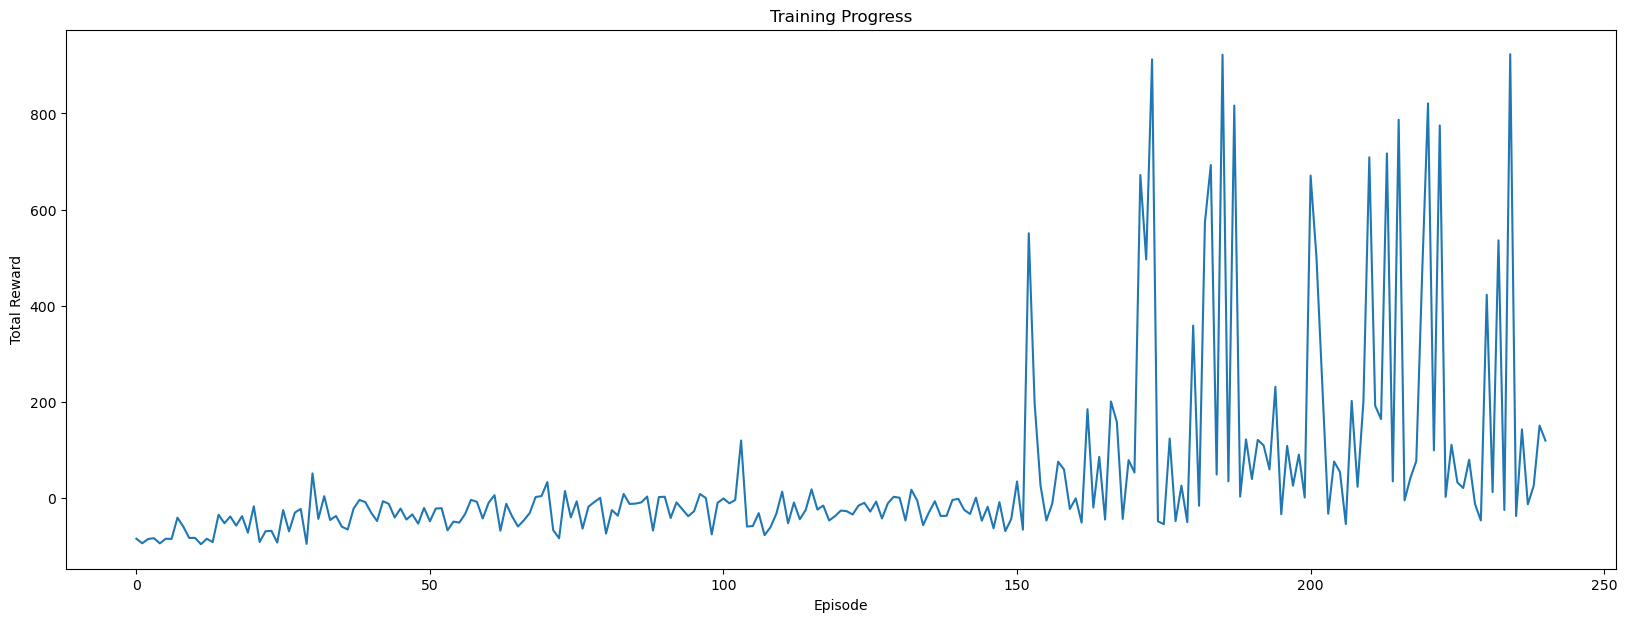

In [ ]:
# Setup

# road parameters
data_points= [(0, 0), (0, 10)] # road shape
road_width=1
road_length =10
closed=False

# car parameters
n_sensors = 5         # Number of sensors
resolution = 0.2      # sensor reolution
max_sensor_range = 3 # sensors range


# NN parameters
state_dim = n_sensors  * max_sensor_range / resolution   # State dimension is the number of sensor
action_dim = 7  # Actions for steering

Action_value = np.linspace(-1,1,action_dim)

road_env = RoadEnvironment(data_points, road_width,road_length, closed)
car_env = CarEnvironment(road_env,n_sensors, resolution, max_sensor_range, Action_value)


# Create an instance of your QNetwork
q_network = PolicyNetwork(state_dim, action_dim, train_mode = True)

# Train the network
q_network.train(num_episodes=10000)




visualize(road_env,car_env)
print(f'CarEnv = {car_env.trajectory}')

In [247]:
print(car_env.car_state)
print(car_env.trajectory)

{'location': tensor([-1.2314,  5.1314]), 'speed': tensor(0.1000), 'direction': tensor(3.1416)}
[tensor([0., 1.])]


/var/folders/r1/x645pbgd3xj5thyk8kcpqnmw0000gn/T/ipykernel_3556/2426718489.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = torch.tensor(reward, dtype=torch.float32).clone()


CarEnv = [tensor([-0.1218,  1.0000]), array([-0.12320375,  1.0999906 ], dtype=float32), array([-0.12457109,  1.1999812 ], dtype=float32), array([-0.12593843,  1.2999718 ], dtype=float32), array([-0.12730578,  1.3999624 ], dtype=float32), array([-0.12867312,  1.499953  ], dtype=float32), array([-0.13004047,  1.5999436 ], dtype=float32), array([-0.13140781,  1.6999342 ], dtype=float32), array([-0.13277516,  1.7999249 ], dtype=float32), array([-0.1341425,  1.8999155], dtype=float32), array([-0.13550985,  1.9999061 ], dtype=float32), array([-0.1368772,  2.0998967], dtype=float32), array([-0.13824454,  2.1998873 ], dtype=float32), array([-0.13961188,  2.299878  ], dtype=float32), array([-0.14097923,  2.3998685 ], dtype=float32), array([-0.14234658,  2.499859  ], dtype=float32), array([-0.14371392,  2.5998497 ], dtype=float32), array([-0.14508127,  2.6998403 ], dtype=float32), array([-0.14644861,  2.799831  ], dtype=float32), array([-0.14781596,  2.8998215 ], dtype=float32), array([-0.149183

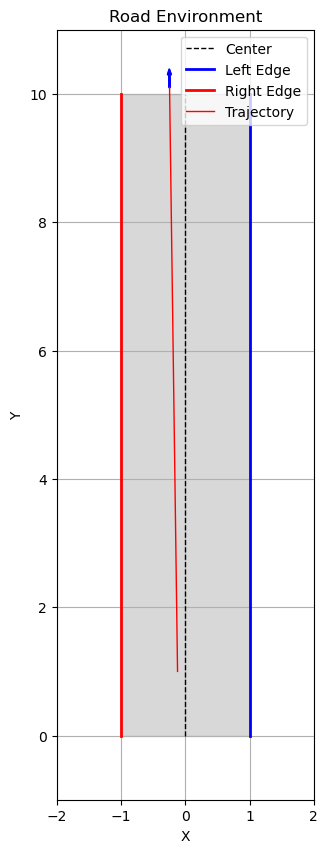

In [477]:
def run_episode(car_env, agent, max_steps):

    done = False
    total_reward = 0
    trajectory = [car_env.car_state["location"]]

    for _ in range(max_steps):
        state = car_env.get_state()
        state_tensor, action, _, done, _ = agent.get_action(state)
        trajectory.append(car_env.car_state["location"])

        if done:
            break

    print(f'CarEnv = {car_env.trajectory}')
    return trajectory



# # road parameters
# data_points= [(0, 0), (0, 10)] # road shape
# road_width=1
# road_length =10
# closed=False

# # car parameters
# n_sensors = 5         # Number of sensors
# resolution = 0.1      # sensor reolution
# max_sensor_range = 3 # sensors range


# # NN parameters
# state_dim = n_sensors  * max_sensor_range / resolution   # State dimension is the number of sensor
# action_dim = 5  # Actions for steering
# Action_value = .25*np.linspace(-1,1,action_dim)

# Load the saved model
loaded_agent = PolicyNetwork(state_dim, action_dim, train_mode = False)
loaded_agent.load_state_dict(torch.load('car_policy.pth'))
loaded_agent.eval()  # Set the network to evaluation mode



road_env = RoadEnvironment(data_points, road_width,road_length, closed)
car_env = CarEnvironment(road_env,n_sensors, resolution, max_sensor_range, Action_value)



# Run and visualize test episodes
num_test_episodes = 5
max_steps = 100


trajectory = run_episode(car_env, loaded_agent, max_steps)
# print(f"Test Episode {episode + 1}, Total Reward: {total_reward}")
visualize(road_env, car_env)
    

## DDPG

In [ ]:
https://www.youtube.com/watch?v=ljHwbY9QrJU

In [ ]:
# actor

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x) 
    
# critic

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x) 

In [ ]:



class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, action_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x) 

class Agent:
    def __init__(self, state_dim, action_dim, lr=0.001):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.state_dim = state_dim
        self.action_dim = action_dim

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.policy(state)
        return action.item(), torch.log(torch.abs(action) + 1e-8)  # Return action and log probability

    def update(self, rewards, log_probs):
        returns = self.compute_returns(rewards)
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)
        policy_loss = torch.stack(policy_loss).sum()
        
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

    def compute_returns(self, rewards, gamma=0.99):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

def train(env, agent, num_episodes, max_steps):
    all_rewards = []
    fig, ax = plt.subplots(figsize=(10, 5))
    line, = ax.plot([], [])
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.set_title('Training Progress')
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        log_probs = []
        rewards = []

        for step in range(max_steps):
            action, log_prob = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            episode_reward += reward

            if done:
                break

            state = next_state

        agent.update(rewards, log_probs)
        all_rewards.append(episode_reward)

        if episode % 100 == 0:
            # print(f"Episode {episode}, Total Reward: {episode_reward}")
            # Update the plot
            line.set_xdata(range(len(all_rewards)))
            line.set_ydata(all_rewards)
            ax.relim()
            ax.autoscale_view()
            display.clear_output(wait=True)
            display.display(fig)
            plt.pause(0.1)


    return all_rewards         
            
# Setup and training

n_sensors = 5  # Number of sensors
state_dim = n_sensors  # State dimension is the number of sensors
action_dim = 1  # Action dimension is 1 for steering

road_env = RoadEnvironment(data_points= [(0, 0), (0, 10)], road_width=1,road_length =10, closed=False, resolution=0.1)
car_env = CarEnvironment(road_env,n_sensors)



agent = Agent(state_dim, action_dim)
num_episodes = 1000
max_steps = 200

try:
    all_rewards = train(car_env, agent, num_episodes, max_steps)
    # Save the trained model
    torch.save(agent.policy.state_dict(), 'car_policy.pth')
    print("Model saved successfully!")
    # Final plot
    plt.figure(figsize=(12, 6))
    plt.plot(all_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()
    
    
except Exception as e:
    print(f"An error occurred: {e}")
    print(f"Current state: {car_env._get_state()}")
    print(f"Car location: {car_env.car_state['location']}")
    print(f"Car direction: {car_env.car_state['direction']}")
    print(f'CarEnv = {car_env.trajectory}')

visualize(road_env,car_env)

# Train

# Test

In [146]:
def run_episode(env, agent, max_steps):
    state = env.reset()
    done = False
    total_reward = 0
    trajectory = [env.car_state["location"].copy()]

    for _ in range(max_steps):
        action, _ = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        trajectory.append(env.car_state["location"])

        if done:
            break

        state = next_state

    return trajectory, total_reward

In [147]:
# Load the saved model
loaded_agent = Agent(state_dim, action_dim)
loaded_agent.policy.load_state_dict(torch.load('car_policy.pth'))
loaded_agent.policy.eval()  # Set the network to evaluation mode

n_sensors = 5  # Number of sensors
state_dim = n_sensors  # State dimension is the number of sensors
action_dim = 1  # Action dimension is 1 for steering

road_env = RoadEnvironment(data_points= [(0, 0), (0, 10)], road_width=1,road_length =15, closed=False, resolution=0.1)
car_env = CarEnvironment(road_env,n_sensors)

# Run and visualize test episodes
num_test_episodes = 5
max_steps = 20

for episode in range(num_test_episodes):
    trajectory, total_reward = run_episode(car_env, loaded_agent, max_steps)
    print(f"Test Episode {episode + 1}, Total Reward: {total_reward}")
    visualize(RoadEnv,CarEnv)




NameError: name 'Agent' is not defined

In [ ]:
RoadEnv = RoadEnvironment(data_points= [(0, 0), (0, 10)], road_width=1,road_length =15, closed=False, resolution=0.1)
CarEnv  = CarEnvironment(RoadEnv,n_sensors =5)
car_agent = CarAgent()



while not CarEnv.Terminal:
    action = car_agent.act(CarEnv.car_state)
    CarEnv.step(action)


print(f'CarEnv = {CarEnv.trajectory}')
visualize(RoadEnv,CarEnv)

In [ ]:
random.uniform(-.4, .4)+np.pi/2 

In [ ]:
x = np.linspace(-1,1,10)
for i in x:
    print((5*(1-abs(i)))**2)